<a href="https://colab.research.google.com/github/ryyutku/DSGP/blob/anuk/DSGP/Modelling/Demand_forecast_model_6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training models at different stages of EDA**

In [589]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from prophet import Prophet

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [590]:
df = pd.read_csv('CIEC.csv')

In [591]:
df.shape

(262, 21)

In [592]:
df.columns

Index(['date', 'fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties ',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'New Vehicle Registrations', 'Vehicle Sales', 'Vehicle Sales Asia',
       'No.of Vessels Colombo', 'Imports of Refined Products',
       'Tax income profits_gains', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel'],
      dtype='object')

In [593]:
df['date'] = pd.to_datetime(df['date'])

In [594]:
features = ['date','fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'GDP: Gross National Income', 'Government Debt',
       'New Vehicle Registrations', 'Vehicle Sales', 'Port Stay Duration',
       'Vehicle Sales Asia', 'No.of Vessels Colombo',
       'Imports of Refined Products', 'Colombo port calls',
       'Tax income profits_gains', 'Tax on Export', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel', 'Household_income',
       'Fuel_other_manufacture']

In [595]:
df_original = df.copy()

## **Checking the time frame with the most columns available**

In [596]:
print(df.isnull().sum())

date                                         0
fuel_consumption                             0
petroleum_imports_crudeOil                   0
Taxes_on_Customs_and_Other_Import Duties     0
Foreign Direct Investments                   0
GDP Goods and Services                       1
New Vehicle Registrations                    0
Vehicle Sales                                0
Vehicle Sales Asia                           0
No.of Vessels Colombo                        0
Imports of Refined Products                  0
Tax income profits_gains                     0
Tax Goods & Services                         0
Tax Road Transport                           0
GDP FCE Households                           1
Diesel User Price                            0
Petrol User Price                            0
Consumption_Oil                              0
Sales 90 Octane                              0
Sales 95 Octane                              0
Sales Auto Diesel                            0
dtype: int64


In [597]:
len(df.columns)

21

In [598]:
df.dtypes

,0
date,datetime64[ns]
fuel_consumption,float64
petroleum_imports_crudeOil,float64
Taxes_on_Customs_and_Other_Import Duties,float64
Foreign Direct Investments,float64
GDP Goods and Services,float64
New Vehicle Registrations,float64
Vehicle Sales,float64
Vehicle Sales Asia,float64
No.of Vessels Colombo,float64


# Exploratory Data Analysis

## **Outlier detection**

In [599]:
#Detecting outliers using Zscore
import pandas as pd
import numpy as np
from scipy.stats import zscore

def detect_outliers_zscore(df, feature, threshold=2, time_column='date'):
    df = df.copy()

    # Skip non-numeric columns
    if not np.issubdtype(df[feature].dtype, np.number):
        print(f"Skipping non-numeric column: {feature}")
        return None, df  # Skip non-numeric columns

    # Drop rows with missing values in the feature column
    df = df.dropna(subset=[feature])

    # Calculate Z-scores for the feature
    df['zscore'] = zscore(df[feature])

    # Identify anomalies based on the Z-score threshold
    df[feature + '_isanomaly'] = (df['zscore'].abs() > threshold)

    # Filter anomaly data
    anomalies = df[df[feature + '_isanomaly']]

    # Select numerical output
    anomalies = anomalies[[time_column, feature, 'zscore', feature + '_isanomaly']]

    return anomalies, df



In [600]:
processed_df = df.copy()

for feature in df.columns:
    print("----", feature, "----")
    anomalies, processed_df = detect_outliers_zscore(processed_df, feature=feature, threshold=2)

    if anomalies is not None:
        print(f"Feature: {feature}")
        print(anomalies.head())
    print()

---- date ----
Skipping non-numeric column: date

---- fuel_consumption ----
Feature: fuel_consumption
Empty DataFrame
Columns: [date, fuel_consumption, zscore, fuel_consumption_isanomaly]
Index: []

---- petroleum_imports_crudeOil ----
Feature: petroleum_imports_crudeOil
Empty DataFrame
Columns: [date, petroleum_imports_crudeOil, zscore, petroleum_imports_crudeOil_isanomaly]
Index: []

---- Taxes_on_Customs_and_Other_Import Duties  ----
Feature: Taxes_on_Customs_and_Other_Import Duties 
Empty DataFrame
Columns: [date, Taxes_on_Customs_and_Other_Import Duties , zscore, Taxes_on_Customs_and_Other_Import Duties _isanomaly]
Index: []

---- Foreign Direct Investments ----
Feature: Foreign Direct Investments
Empty DataFrame
Columns: [date, Foreign Direct Investments, zscore, Foreign Direct Investments_isanomaly]
Index: []

---- GDP Goods and Services ----
Feature: GDP Goods and Services
Empty DataFrame
Columns: [date, GDP Goods and Services, zscore, GDP Goods and Services_isanomaly]
Index: 

In [601]:
processed_df.columns

Index(['date', 'fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties ',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'New Vehicle Registrations', 'Vehicle Sales', 'Vehicle Sales Asia',
       'No.of Vessels Colombo', 'Imports of Refined Products',
       'Tax income profits_gains', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel', 'zscore',
       'fuel_consumption_isanomaly', 'petroleum_imports_crudeOil_isanomaly',
       'Taxes_on_Customs_and_Other_Import Duties _isanomaly',
       'Foreign Direct Investments_isanomaly',
       'GDP Goods and Services_isanomaly',
       'New Vehicle Registrations_isanomaly', 'Vehicle Sales_isanomaly',
       'Vehicle Sales Asia_isanomaly', 'No.of Vessels Colombo_isanomaly',
       'Imports of Refined Products_isanomaly',
    

### **Removing the outliers**

In [602]:
# Removing anomalies
processed_df = processed_df[processed_df['New Vehicle Registrations_isanomaly'] == False]
processed_df = processed_df[processed_df['No.of Vessels Colombo_isanomaly'] == False]
processed_df = processed_df[processed_df['Imports of Refined Products_isanomaly'] == False]
processed_df = processed_df[processed_df['Tax Road Transport_isanomaly'] == False]
processed_df = processed_df[processed_df['Petrol User Price_isanomaly'] == False]
processed_df = processed_df[processed_df['Sales 90 Octane_isanomaly'] == False]

### **Test running a model**

In [603]:
# Drop anomaly columns
processed_df = processed_df.drop(columns=[col for col in processed_df.columns if '_isanomaly' in col])


In [604]:
# Ensure frequency is set correctly for weekly data
processed_df = processed_df.resample('W', on='date').mean()  # Aggregates if needed

# Handle missing values after frequency conversion
processed_df = processed_df.fillna(method='ffill')

<ipython-input-604-79601d892efe>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df = processed_df.fillna(method='ffill')


In [605]:
# Scaling
from sklearn.preprocessing import StandardScaler

# Define features to scale (exclude 'date' and 'fuel_consumption' if it's the target)
features_to_scale = processed_df.drop(columns=['fuel_consumption']).columns # 'date'

scaler = StandardScaler()
processed_df[features_to_scale] = scaler.fit_transform(processed_df[features_to_scale])

In [606]:
def train_arima(df, target_col, order=(5, 1, 0), train_ratio=0.8):
    # Train-test split
    train_size = int(len(df) * train_ratio)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    # Train ARIMA model
    arima_model = ARIMA(train[target_col], order=order)
    arima_result = arima_model.fit()

    # Forecast
    arima_forecast = arima_result.forecast(steps=len(test))

    # Evaluate
    arima_mae = mean_absolute_error(test[target_col], arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(test[target_col], arima_forecast))

    print(f"ARIMA MAE: {arima_mae:.4f}")
    print(f"ARIMA RMSE: {arima_rmse:.4f}")

    residuals = test[target_col] - arima_forecast
    print(residuals.describe())

    return arima_mae,arima_rmse,arima_forecast


In [607]:
arima_mae, arima_rmse, arima_forecast = train_arima(processed_df, target_col='fuel_consumption', order=(5, 1, 0), train_ratio=0.8)

ARIMA MAE: 0.0883
ARIMA RMSE: 0.0891
count    53.000000
mean      0.088302
std       0.012362
min       0.000000
25%       0.090000
50%       0.090000
75%       0.090000
max       0.090000
dtype: float64


In [608]:
def train_prophet(df, target_col, train_ratio=0.8):
    # Prepare dataset for Prophet
    prophet_df = df.reset_index()[['date', target_col]]
    prophet_df.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (target)

    # Train-test split
    train_size = int(len(prophet_df) * train_ratio)
    train_prophet, test_prophet = prophet_df.iloc[:train_size], prophet_df.iloc[train_size:]

    # Train Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_prophet)

    # Make future predictions
    future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='W')
    forecast = prophet_model.predict(future)

    # Extract only the relevant forecasted values
    prophet_forecast = forecast.iloc[-len(test_prophet):]['yhat'].values

    # Evaluate
    prophet_mae = mean_absolute_error(test_prophet['y'], prophet_forecast)
    prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_forecast))

    print(f"Prophet MAE: {prophet_mae:.4f}")
    print(f"Prophet RMSE: {prophet_rmse:.4f}")

    return prophet_mae,prophet_rmse,prophet_forecast



In [609]:
prophet_mae,prophet_rmse,prophet_forecast = train_prophet(processed_df, target_col='fuel_consumption', train_ratio=0.8)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqrbozmz/yf83dtn_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqrbozmz/v77k_gfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94683', 'data', 'file=/tmp/tmpyqrbozmz/yf83dtn_.json', 'init=/tmp/tmpyqrbozmz/v77k_gfk.json', 'output', 'file=/tmp/tmpyqrbozmz/prophet_model4gw4u037/prophet_model-20250318011021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:10:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 0.0932
Prophet RMSE: 0.0941


In [610]:
def train_random_forest(df, target_col, train_ratio=0.8, n_estimators=100):
    # Define features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Train-test split
    train_size = int(len(df) * train_ratio)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict
    rf_predictions = rf_model.predict(X_test)

    # Evaluate
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

    print(f"RandomForest MAE: {rf_mae:.4f}")
    print(f"RandomForest RMSE: {rf_rmse:.4f}")

    # Feature Importance
    feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).nlargest(10)
    print("\nTop 10 Important Features:")
    print(feature_importances)

    return rf_mae, rf_rmse, feature_importances

In [611]:
rf_mae, rf_rmse, feature_importances = train_random_forest(processed_df, target_col='fuel_consumption', train_ratio=0.8, n_estimators=100)

RandomForest MAE: 0.0842
RandomForest RMSE: 0.0850

Top 10 Important Features:
Tax income profits_gains      0.102969
Vehicle Sales                 0.089818
Petrol User Price             0.076794
GDP Goods and Services        0.076760
Tax Goods & Services          0.068773
petroleum_imports_crudeOil    0.061504
Sales 90 Octane               0.058475
Tax Road Transport            0.056462
Sales 95 Octane               0.055168
Foreign Direct Investments    0.048606
dtype: float64


## **ADF Test**

In [612]:
from statsmodels.tsa.stattools import adfuller

def stationary_test(df, feature):
    df = df.copy()
    result = adfuller(feature.dropna())  # ADF test result
    adf_results = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

    # Determine if series is stationary based on the ADF test
    if result[1] < 0.05:  # If p-value < 0.05, we reject the null hypothesis (non-stationary)
        is_stationary = True
    else:
        is_stationary = False

    # Checking if ADF statistic is less than critical values at 5% level
    if result[0] < adf_results['Critical Values']['5%']:
        stationary_check = True  # Rejects the null hypothesis
    else:
        stationary_check = False  # Fails to reject the null hypothesis

    # Output results with the determination of stationarity
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    print(f"Is Stationary Based on p-value: {is_stationary}")
    print(f"Is Stationary Based on ADF Statistic vs Critical Value: {stationary_check}")
    print()

    return adf_results, is_stationary, stationary_check

In [613]:
for feature in df:
  print(f"Performing stationary test for {feature}")
  adf_results = stationary_test(df,df[feature])
  print(adf_results)
  print()

Performing stationary test for date
ADF Statistic: -0.6264795966746579
p-value: 0.8648857725976149
Critical Values: {'1%': -3.4561550092339512, '5%': -2.8728972266578676, '10%': -2.5728222369384763}
Is Stationary Based on p-value: False
Is Stationary Based on ADF Statistic vs Critical Value: False

({'ADF Statistic': -0.6264795966746579, 'p-value': 0.8648857725976149, 'Critical Values': {'1%': -3.4561550092339512, '5%': -2.8728972266578676, '10%': -2.5728222369384763}}, False, False)

Performing stationary test for fuel_consumption
ADF Statistic: -1.4867982824734087
p-value: 0.5400316383507306
Critical Values: {'1%': -3.4556556713934934, '5%': -2.872678352489859, '10%': -2.57270548832225}
Is Stationary Based on p-value: False
Is Stationary Based on ADF Statistic vs Critical Value: False

({'ADF Statistic': -1.4867982824734087, 'p-value': 0.5400316383507306, 'Critical Values': {'1%': -3.4556556713934934, '5%': -2.872678352489859, '10%': -2.57270548832225}}, False, False)

Performing sta

Need to perform differences on the data as it is a non-stationary dataset

### **Making the dataset Stationary**

In [614]:
stationary_df = df.copy()

In [615]:
stationary_df.shape

(262, 21)

In [616]:
stationary_df = stationary_df.diff(periods=1)

In [617]:
stationary_df = stationary_df.dropna()

### **Test Training a Model**

In [618]:
arima_mae, arima_rmse, arima_forecast = train_arima(stationary_df, target_col='fuel_consumption', order=(5, 1, 0), train_ratio=0.8)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA MAE: 0.0017
ARIMA RMSE: 0.0125
count     5.000000e+01
mean      1.800000e-03
std       1.272792e-02
min      2.597805e-139
25%      3.415106e-139
50%      3.415255e-139
75%      3.416299e-139
max       9.000000e-02
dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [620]:
prophet_mae,prophet_rmse,prophet_forecast = train_prophet(stationary_df, target_col='fuel_consumption', train_ratio=0.8)

TypeError: dtype timedelta64[ns] cannot be converted to datetime64[ns]

In [621]:
rf_mae, rf_rmse, feature_importances = train_random_forest(stationary_df, target_col='fuel_consumption', train_ratio=0.8, n_estimators=100)

DTypePromotionError: The DType <class 'numpy.dtypes.TimeDelta64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.TimeDelta64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

### **Performing ADF test again**

In [622]:
# # Check if there are NaNs or constant values after differencing
# df = stationary_df.select_dtypes(include=[np.number])

# for feature in df.columns:
#     if df[feature].nunique() > 1:  # Ensure that the column has more than one unique value (not constant)
#         print(f"Performing stationary test for {feature}")
#         adf_results = stationary_test(df, df[feature])
#         print(adf_results)
#     else:
#         print(f"Skipping {feature} as it is constant or contains NaNs after differencing.")
#     print()


In [623]:
# Check if there are NaNs or constant values after differencing
def check_stationary(df):
  for feature in df.columns:
      if df[feature].nunique() > 1:  # Ensure that the column has more than one unique value (not constant)
          print(f"Performing stationary test for {feature}")
          adf_results = stationary_test(df, df[feature])
          print(adf_results)
      else:
          print(f"Skipping {feature} as it is constant or contains NaNs after differencing.")
      print()


In [624]:
check_stationary(stationary_df.select_dtypes(include=[np.number]))

Skipping date as it is constant or contains NaNs after differencing.

Performing stationary test for fuel_consumption
ADF Statistic: -16.087931399588197
p-value: 5.291532254095479e-29
Critical Values: {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}
Is Stationary Based on p-value: True
Is Stationary Based on ADF Statistic vs Critical Value: True

({'ADF Statistic': -16.087931399588197, 'p-value': 5.291532254095479e-29, 'Critical Values': {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}}, True, True)

Performing stationary test for petroleum_imports_crudeOil
ADF Statistic: -16.046517757205006
p-value: 5.836776100742741e-29
Critical Values: {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}
Is Stationary Based on p-value: True
Is Stationary Based on ADF Statistic vs Critical Value: True

({'ADF Statistic': -16.046517757205006, 'p-value': 5.836776100742741e-29, 'Critical Values': {'1%': -3.455853

In [625]:
stationary_df = stationary_df.drop(columns=['New Vehicle Registrations'])

Test training the dataset again

In [626]:
arima_mae, arima_rmse, arima_forecast = train_arima(stationary_df, target_col='fuel_consumption', order=(5, 1, 0), train_ratio=0.8)

ARIMA MAE: 0.0017
ARIMA RMSE: 0.0125
count     5.000000e+01
mean      1.800000e-03
std       1.272792e-02
min      2.597805e-139
25%      3.415106e-139
50%      3.415255e-139
75%      3.416299e-139
max       9.000000e-02
dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

In [627]:
prophet_mae,prophet_rmse,prophet_forecast = train_prophet(stationary_df, target_col='fuel_consumption', train_ratio=0.8)

TypeError: dtype timedelta64[ns] cannot be converted to datetime64[ns]

In [628]:
rf_mae, rf_rmse, feature_importances = train_random_forest(stationary_df, target_col='fuel_consumption', train_ratio=0.8, n_estimators=100)

DTypePromotionError: The DType <class 'numpy.dtypes.TimeDelta64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.TimeDelta64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

## **Rolling statistics**

In [629]:
import matplotlib.pyplot as plt

def rolling_stats(df, feature, window=4):
    df = df.copy()  # Ensure df is properly copied
    if df[feature].dtype not in ['int64', 'float64']:  # Skip non-numeric columns
        print(f"Skipping {feature}: Not a numeric column")
        return

    df[feature + "_rmean"] = df[feature].rolling(window=window).mean()

    # Plot original feature and rolling mean
    df[[feature, feature + "_rmean"]].plot(figsize=(6, 3), title="Rolling Mean of " + feature)
    plt.show()

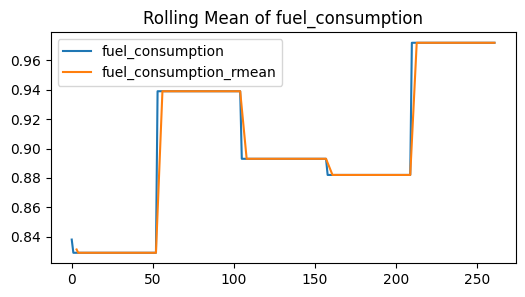

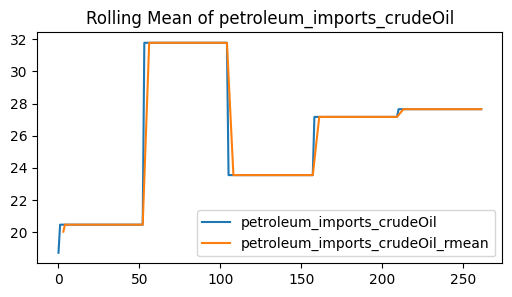

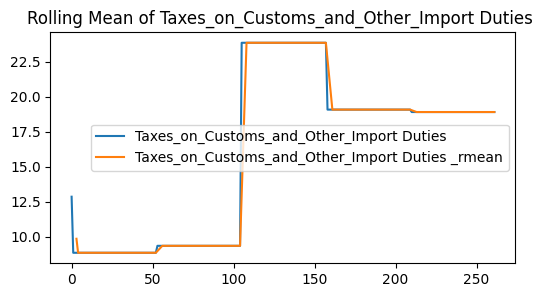

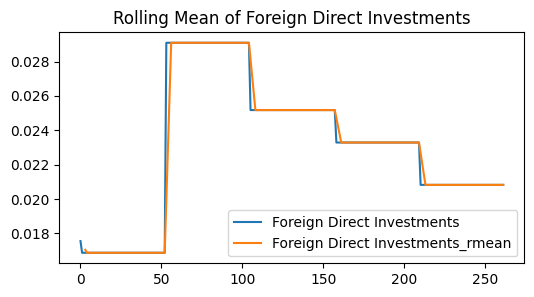

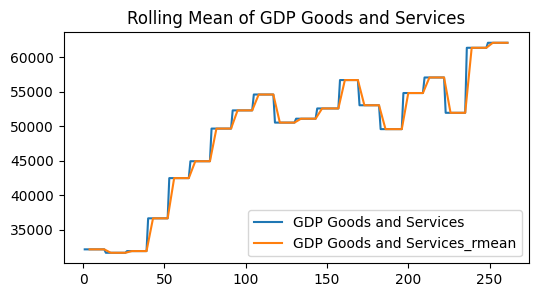

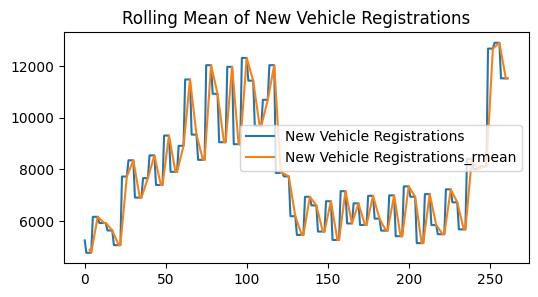

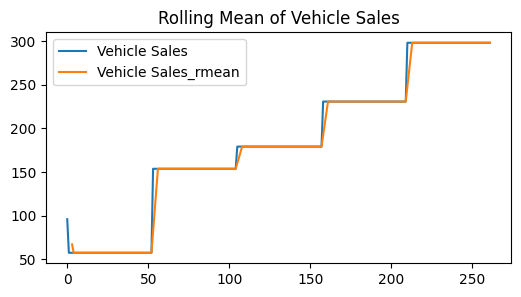

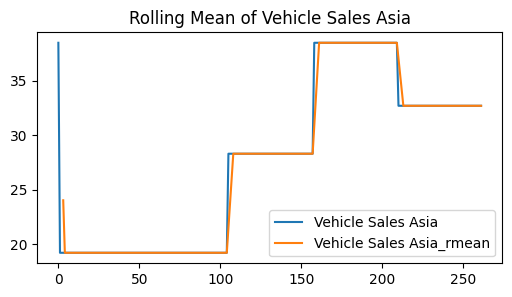

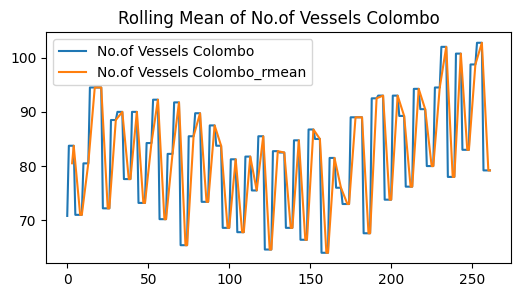

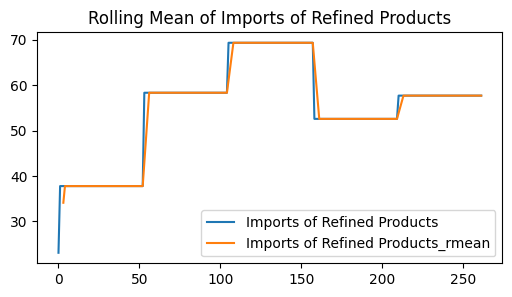

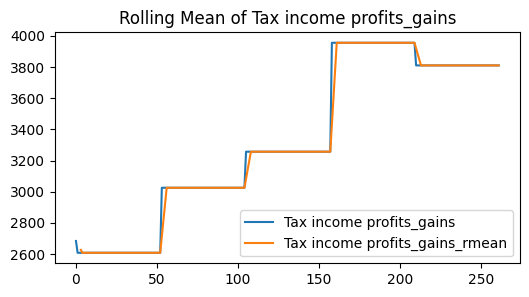

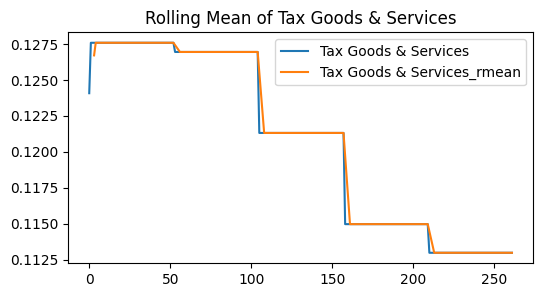

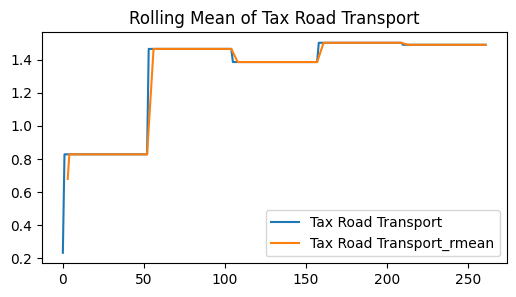

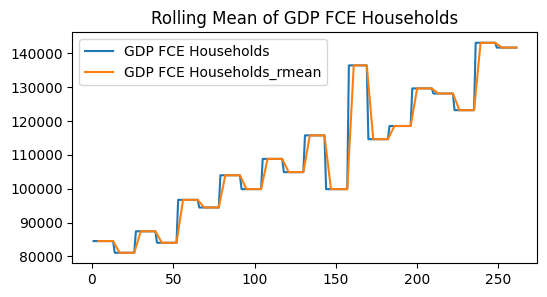

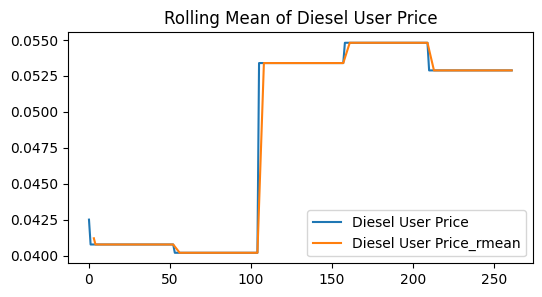

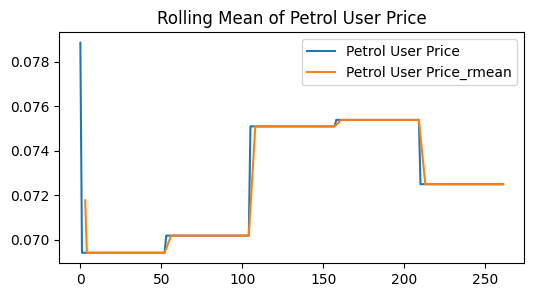

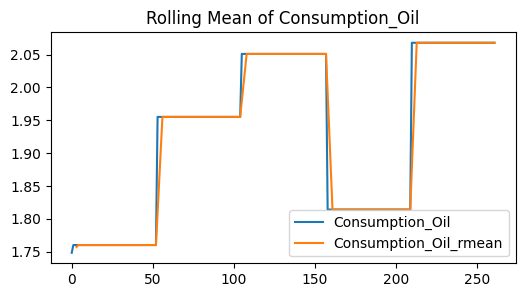

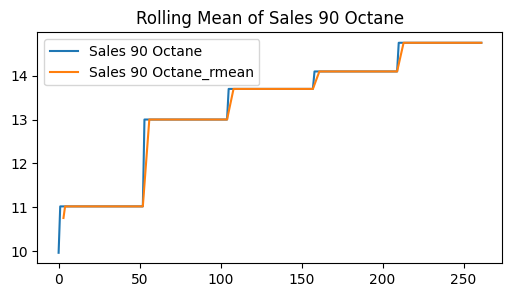

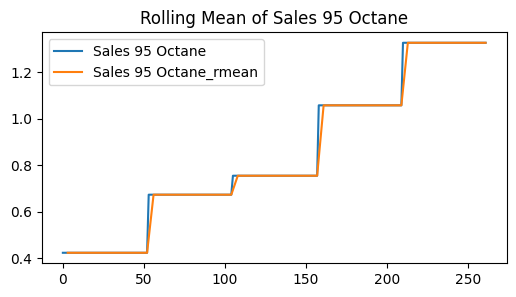

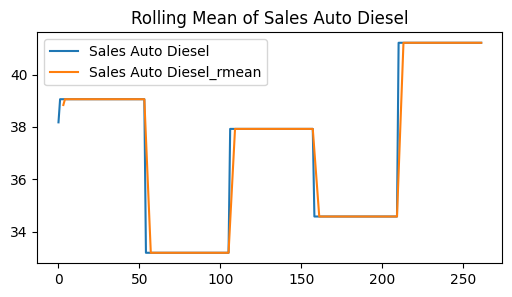

In [634]:
# Iterate only over numeric columns
for feature in df.select_dtypes(include=['number']).columns:
    rolling_stats(df, feature,window=4)

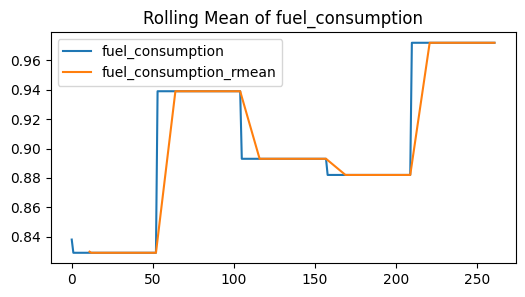

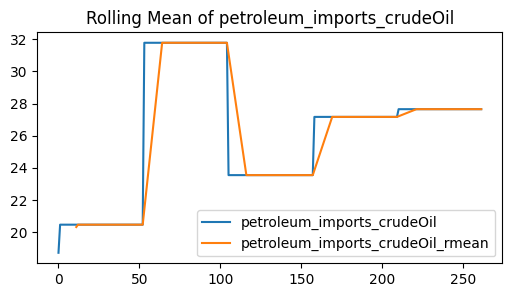

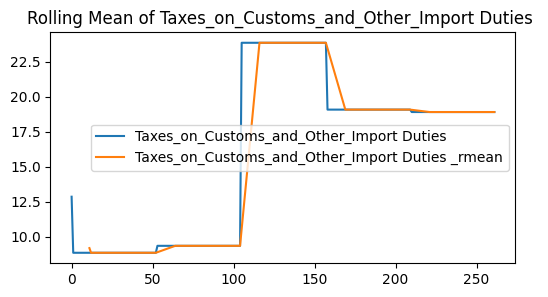

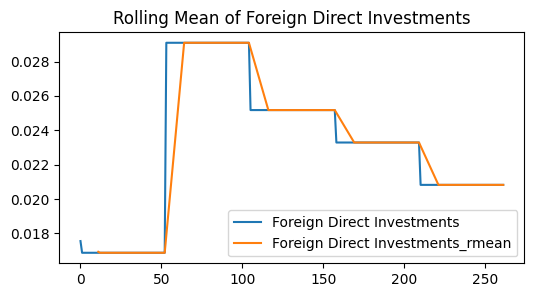

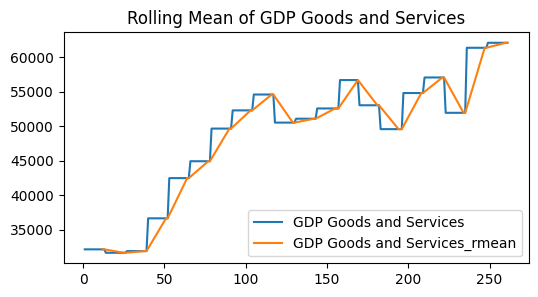

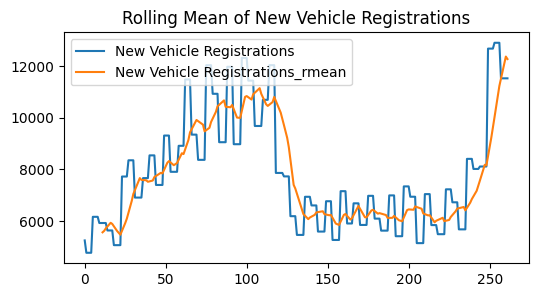

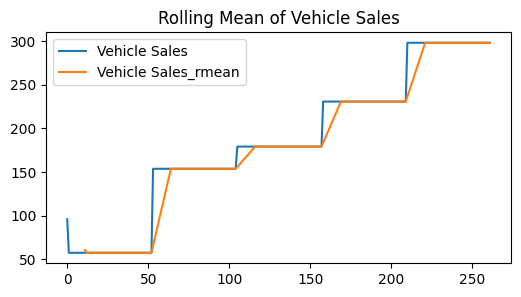

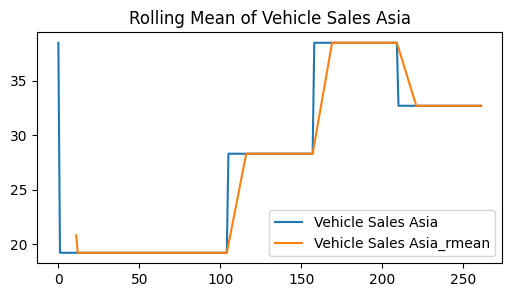

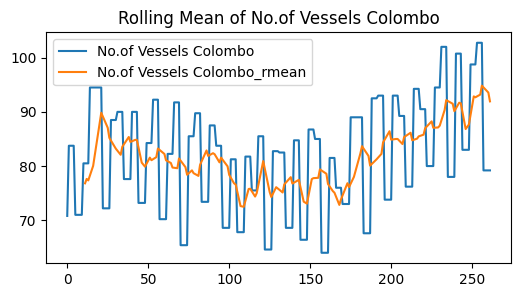

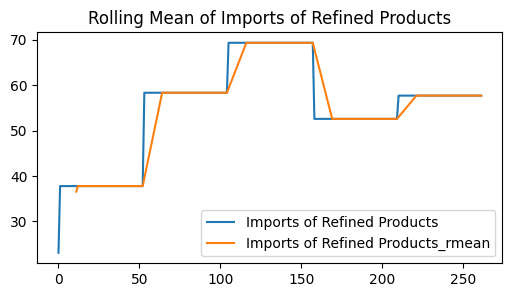

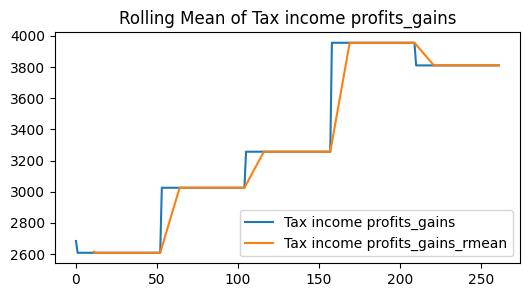

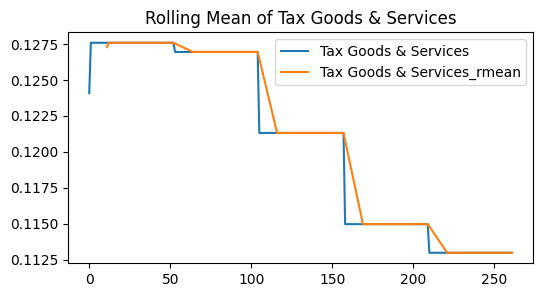

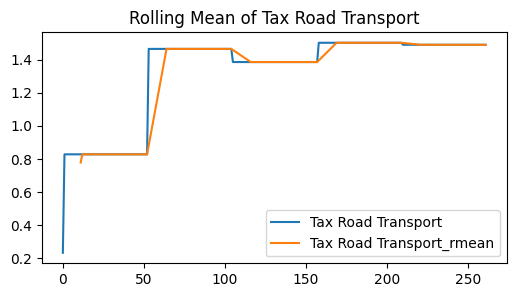

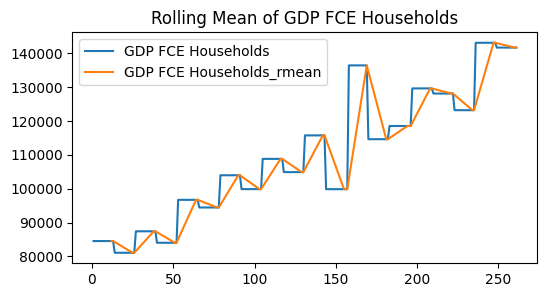

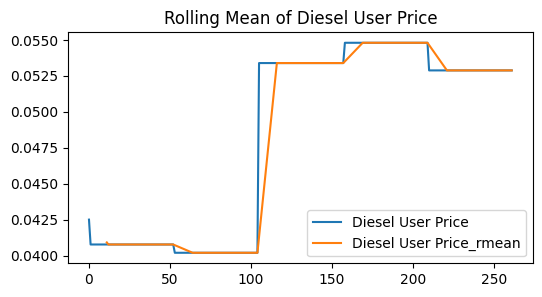

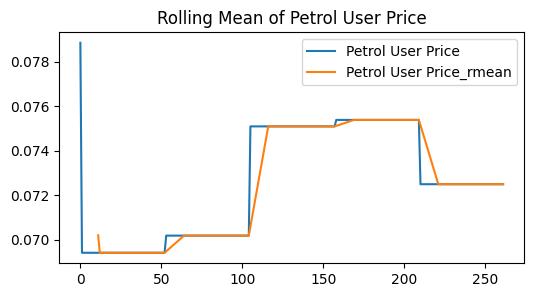

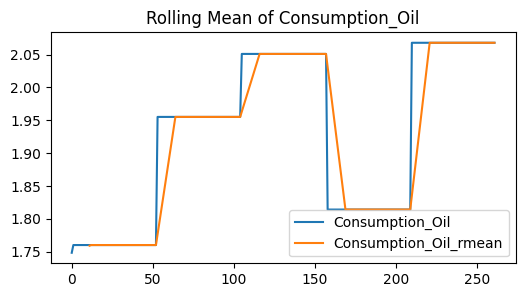

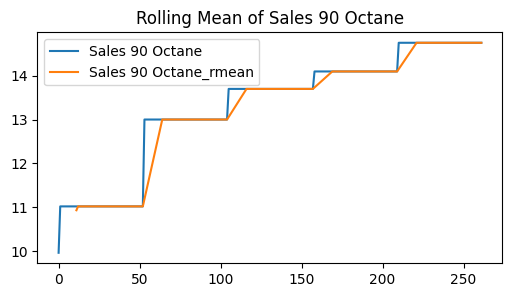

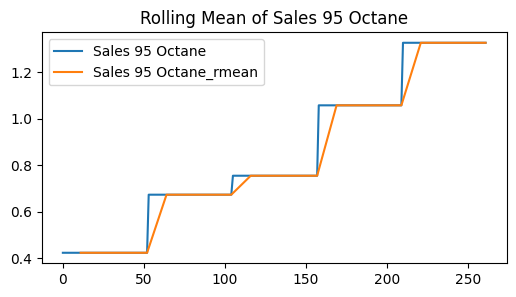

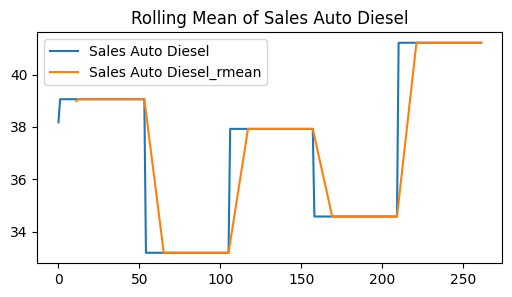

In [637]:
for feature in df.select_dtypes(include=['number']).columns:
    rolling_stats(df, feature,window=12)

Skipping date: Not a numeric column


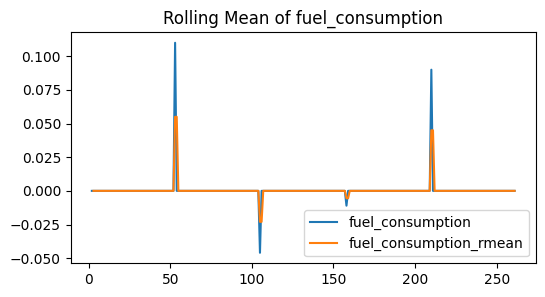

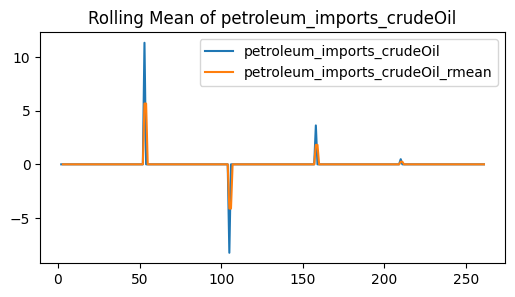

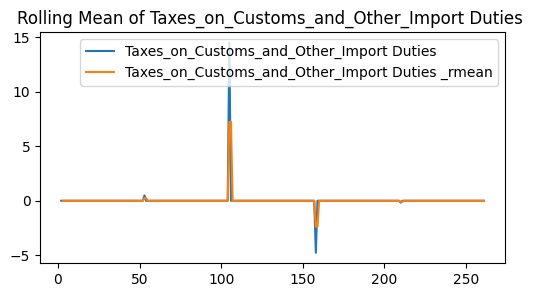

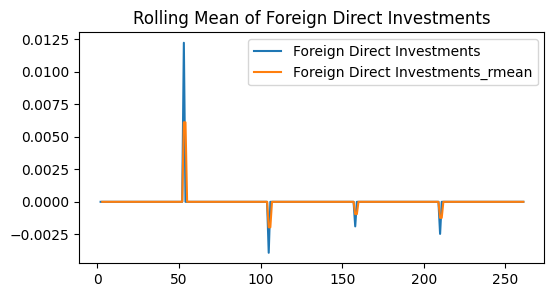

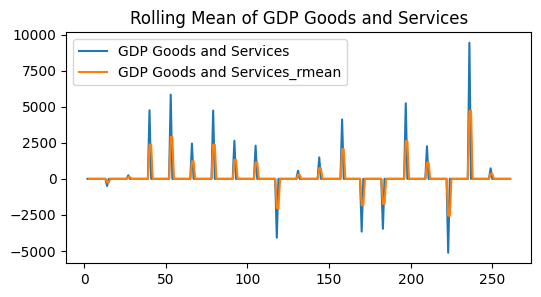

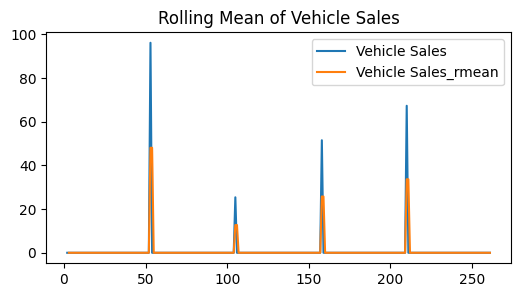

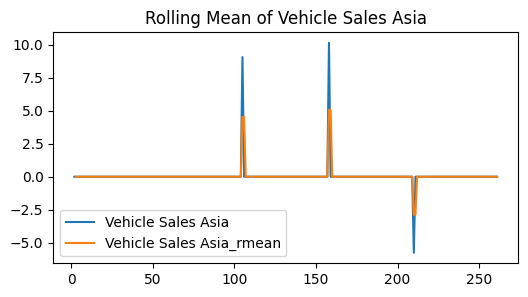

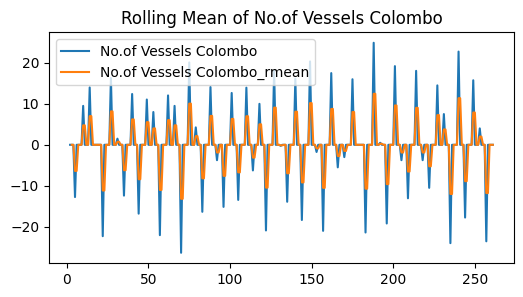

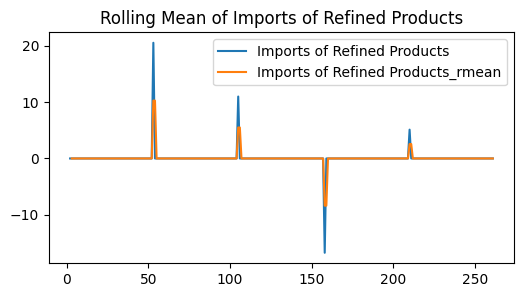

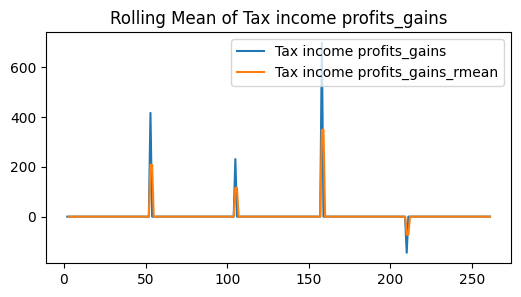

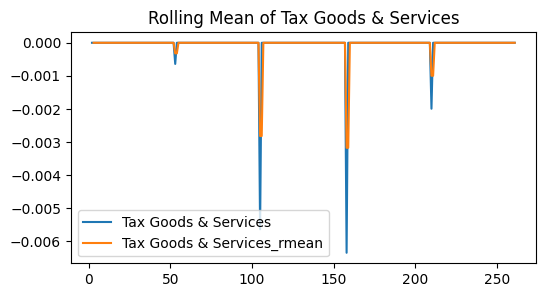

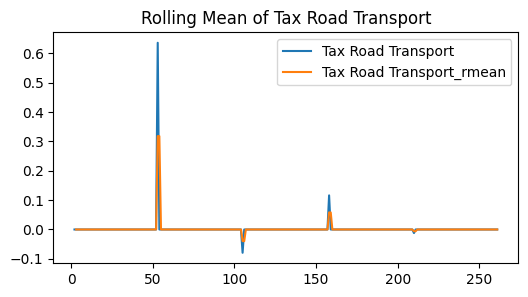

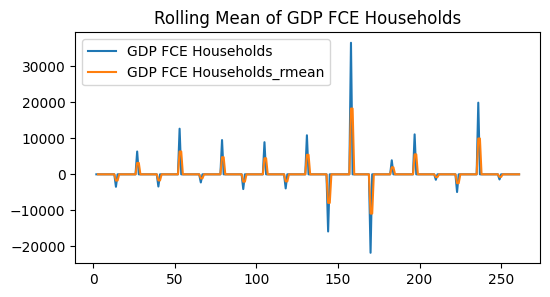

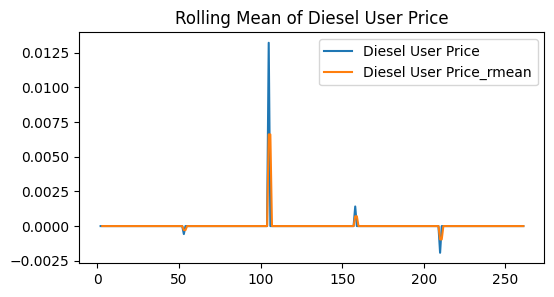

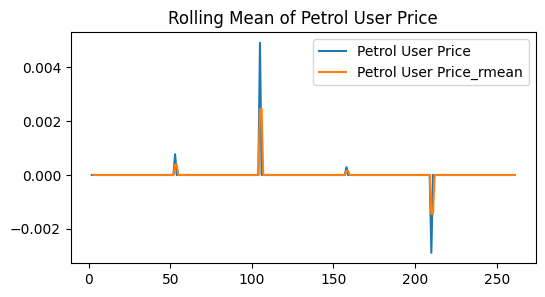

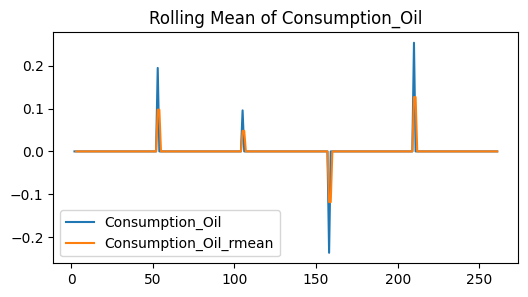

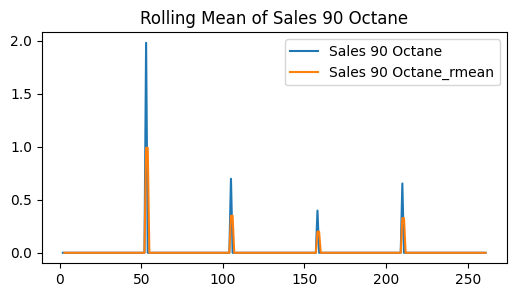

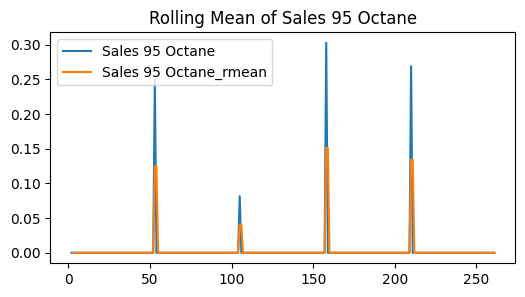

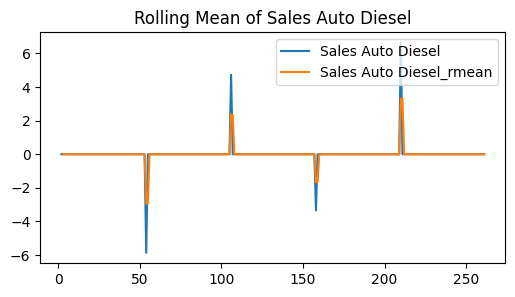

In [640]:
for feature in stationary_df.select_dtypes(include=['number']).columns:
    rolling_stats(stationary_df, feature,window=2)

### **Augmenting and Transforming the stationary dataset according to rolling statistics**

In [642]:
stationary_df.columns

Index(['date', 'fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties ',
       'Foreign Direct Investments', 'GDP Goods and Services', 'Vehicle Sales',
       'Vehicle Sales Asia', 'No.of Vessels Colombo',
       'Imports of Refined Products', 'Tax income profits_gains',
       'Tax Goods & Services', 'Tax Road Transport', 'GDP FCE Households',
       'Diesel User Price', 'Petrol User Price', 'Consumption_Oil',
       'Sales 90 Octane', 'Sales 95 Octane', 'Sales Auto Diesel'],
      dtype='object')

In [645]:
for feature in stationary_df.columns:
    if feature != 'fuel_consumption':  # Skip self-correlation
        corr_value = stationary_df['fuel_consumption'].corr(stationary_df[feature])
        print(f"Correlation with {feature}: {corr_value:.4f}")

Correlation with date: nan
Correlation with petroleum_imports_crudeOil: 0.7508
Correlation with Taxes_on_Customs_and_Other_Import Duties : -0.2546
Correlation with Foreign Direct Investments: 0.6693
Correlation with GDP Goods and Services: 0.2597
Correlation with Vehicle Sales: 0.7607
Correlation with Vehicle Sales Asia: -0.4781
Correlation with No.of Vessels Colombo: 0.0875
Correlation with Imports of Refined Products: 0.5483
Correlation with Tax income profits_gains: 0.1081
Correlation with Tax Goods & Services: 0.0672
Correlation with Tax Road Transport: 0.7290
Correlation with GDP FCE Households: 0.0492
Correlation with Diesel User Price: -0.4320
Correlation with Petrol User Price: -0.4720
Correlation with Consumption_Oil: 0.6918
Correlation with Sales 90 Octane: 0.7165
Correlation with Sales 95 Octane: 0.6152
Correlation with Sales Auto Diesel: 0.3999


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [650]:
from scipy.stats import boxcox
def rolling_stats_transformation(df, target_col='fuel_consumption'):
    df = df.copy()

    # Ensure 'date' is datetime type
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')  # Set date as index for time-based calculations

    # 1. Rolling Statistics Features
    df['rolling_mean_7'] = df[target_col].rolling(window=7).mean()
    df['rolling_std_7'] = df[target_col].rolling(window=7).std()
    df['rolling_median_7'] = df[target_col].rolling(window=7).median()

    # 2. Exponential Moving Average (EMA)
    df['ema_0.1'] = df[target_col].ewm(alpha=0.1).mean()
    df['ema_0.3'] = df[target_col].ewm(alpha=0.3).mean()

    # 3. Time-Based Features
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)  # 1 if weekend, 0 otherwise

    # 4. Target Variable Transformation
    df['log_fuel_consumption'] = np.log1p(df[target_col])  # Log transformation
    df['boxcox_fuel_consumption'], lambda_bc = boxcox(df[target_col] + 1)  # Box-Cox transformation

    # 5. Interaction Terms
    if 'fuel_price' in df.columns:  # Example: Check if 'fuel_price' exists in the dataset
        df['price_per_demand'] = df['fuel_price'] / (df[target_col] + 1)  # Avoid division by zero

    return df

In [652]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox

def rolling_stats_transformation(df, target_col='fuel_consumption'):
    df = df.copy()

    # Ensure 'date' is a valid datetime type
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    df = df.set_index('date')  # Set date as index for time-based calculations

    # Ensure the index is properly converted
    df.index = pd.to_datetime(df.index)

    # 1. Rolling Statistics Features
    df['rolling_mean_7'] = df[target_col].rolling(window=7).mean()
    df['rolling_std_7'] = df[target_col].rolling(window=7).std()
    df['rolling_median_7'] = df[target_col].rolling(window=7).median()

    # 2. Exponential Moving Average (EMA)
    df['ema_0.1'] = df[target_col].ewm(alpha=0.1).mean()
    df['ema_0.3'] = df[target_col].ewm(alpha=0.3).mean()

    # 3. Time-Based Features
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)  # 1 if weekend, 0 otherwise

    # 4. Target Variable Transformation
    df['log_fuel_consumption'] = np.log1p(df[target_col])  # Log transformation
    df['boxcox_fuel_consumption'], lambda_bc = boxcox(df[target_col] + 1)  # Box-Cox transformation

    # 5. Interaction Terms
    if 'fuel_price' in df.columns:  # Example: Check if 'fuel_price' exists in the dataset
        df['price_per_demand'] = df['fuel_price'] / (df[target_col] + 1)  # Avoid division by zero

    return df

# Apply the transformation
s_df = rolling_stats_transformation(stationary_df)


TypeError: dtype timedelta64[ns] cannot be converted to datetime64[ns]

In [651]:
s_df = rolling_stats_transformation(stationary_df)

AttributeError: 'TimedeltaIndex' object has no attribute 'dayofweek'

## **ACF/PACF Test**

In [ ]:
from statsmodels.tsa.stattools import acf,pacf
def acf_pacf(df,feature):
  acf_values = acf(df[feature].dropna(), nlags=10)
  pacf_values = pacf(df[feature].dropna(), nlags=10)

  acf_df = pd.DataFrame({'Lag':range(11), 'ACF':acf_values})
  pacf_df = pd.DataFrame({'Lag':range(11), 'PACF':pacf_values})
  print("ACF and PACF for ",feature)
  print("Autocorrelation Values:")
  print(acf_df)
  print("\nPartial Autocorrelation Values:")
  print(pacf_df)


In [ ]:
for feature in df.columns:
  acf_pacf(df,feature)

## **ACF/PACF Strength test**

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

def acf_pacf_strength(df, feature, nlags=10):
    acf_values = acf(df[feature].dropna(), nlags=nlags)
    pacf_values = pacf(df[feature].dropna(), nlags=nlags)

    # Compute how quickly ACF declines (higher means strong trend)
    acf_strength = np.sum(np.abs(acf_values[1:])) / nlags  # Ignore lag 0 (always 1)

    # Check if PACF drops off after the first lag (higher means trend)
    pacf_strength = abs(pacf_values[1])  # PACF at lag 1 shows direct correlation

    print(f"{feature}: ACF Strength = {acf_strength:.4f}, PACF Strength = {pacf_strength:.4f}")

    return acf_strength, pacf_strength

# Run for all columns
for feature in df.columns:
    acf_pacf_strength(df, feature)

## **Lag Analysis**

In [ ]:
def lag_analysis(df,feature):
  df[feature+'lag1'] = df[feature].shift(1)

  # Show numerical correlation
  lag_corr = df[[feature,feature+'lag1']].corr().iloc[0,1]
  print("Correlation between",feature,"and its 1-day lag:",lag_corr)

In [ ]:
for feature in df.columns:
  lag_analysis(df,feature)

In [ ]:
df.columns

# Modelling

In [ ]:
df.dropna(inplace=True)

In [ ]:
# Extracting date feature
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['quarter'] = df['date'].dt.quarter

df.drop('date',axis=1,inplace=True)

## **Scaling**

In [ ]:
# Feature scaling
numerical_cols = df.select_dtypes(include=['float64','int64']).columns
numerical_cols = numerical_cols.drop('fuel_consumption')

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

fuel_scaler = StandardScaler()
df['fuel_consumption'] = fuel_scaler.fit_transform(df[['fuel_consumption']])

df.head()

In [ ]:
df.to_csv("data.csv",index=False)

In [ ]:
df.columns

In [ ]:
# splitting data into feature and target variables
X = df.drop('fuel_consumption',axis=1)
y = df['fuel_consumption']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 42)
print("Training shape",X_train.shape)
print("Test df shape",X_test.shape)

In [ ]:
# visualize correlation matrix
corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import plotly.express as px

In [ ]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)


In [ ]:
import plotly.graph_objects as go

# Using Random Forest (replace with y_pred_lr for Linear Regression)
predictions = y_pred_rf  # Replace with y_pred_lr if you're using Linear Regression

# Create traces for actual and predicted values
trace_actual = go.Scatter(
    x=y_test.index, y=y_test, mode='lines+markers', name='Actual Fuel Demand', line=dict(color='blue')
)

trace_predicted = go.Scatter(
    x=y_test.index, y=predictions, mode='lines+markers', name='Predicted Fuel Demand', line=dict(color='red', dash='dash')
)

# Create the layout for the plot
layout = go.Layout(
    title='Actual vs Predicted Fuel Demand (Test Set)',
    xaxis=dict(title='Index (Test Set)'),
    yaxis=dict(title='Fuel Demand'),
    showlegend=True
)

# Plot the figure
fig = go.Figure(data=[trace_actual, trace_predicted], layout=layout)
fig.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Print out all the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


In [ ]:
# Inverse transform on predicted and actual values
predicted_values = fuel_scaler.inverse_transform(predictions.reshape(-1, 1))
actual_values = fuel_scaler.inverse_transform(y_test.values.reshape(-1, 1))


In [ ]:
print(y_test.index)

In [ ]:
# Retrieve corresponding dates from the original dataset
y_test_dates = df_original.loc[y_test.index, 'date']  # Replace 'df_original' with the original dataframe before dropping 'date'

# Convert predictions and actual values back to original scale
predictions = predicted_values.flatten()  # Use inverse-transformed predictions
actuals = actual_values.flatten()  # Use inverse-transformed actual values

# Create traces for actual and predicted values
trace_actual = go.Scatter(
    x=y_test_dates, y=actuals, mode='lines+markers', name='Actual Fuel Demand', line=dict(color='blue')
)

trace_predicted = go.Scatter(
    x=y_test_dates, y=predictions, mode='lines+markers', name='Predicted Fuel Demand', line=dict(color='red', dash='dash')
)

# Create the layout for the plot
layout = go.Layout(
    title='Actual vs Predicted Fuel Demand (Test Set)',
    xaxis=dict(title='Date', tickformat="%Y-%m-%d"),  # Format dates properly
    yaxis=dict(title='Fuel Demand (Original Scale)'),
    showlegend=True
)

# Plot the figure
fig = go.Figure(data=[trace_actual, trace_predicted], layout=layout)
fig.show()


In [ ]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add actual values as scatter plot (points only)
fig.add_trace(go.Scatter(
    x=y_test_dates, y=actuals, mode='markers',
    name='Actual Fuel Demand', marker=dict(color='blue', size=8, symbol='circle')
))

# Add predicted values as scatter plot (points only)
fig.add_trace(go.Scatter(
    x=y_test_dates, y=predictions, mode='markers',
    name='Predicted Fuel Demand', marker=dict(color='red', size=8, symbol='x')
))

# Update layout
fig.update_layout(title="Actual vs Predicted Fuel Demand (Test Set)",
                  xaxis_title="Date", yaxis_title="Fuel Demand",
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=True, zeroline=False),
                  showlegend=True)

fig.show()


## **Predicting future demand**

In [ ]:
# Save the trained model as fuel_demand.pkl
with open("fuel_demand.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("Model saved successfully!")

In [ ]:
df.columns